In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [29]:
   
db = CaseDB()
toload = [
    dict(name="afnE_base", id = "d24bd-cond0.25_frec0.48"),
    dict(name="afnE_qei_x2", id = "d36a-d28a_qei_x2"),
    dict(name="afnE_qei_x4", id = "d36b-qei_x4"),
    dict(name="afnE_qei_x8", id = "d36c-qei_x8")
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case d24bd-cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 10/16/2023, 10:34:08, dmp file date 10/15/2023, 23:08:48

- Reading case d36a-d28a_qei_x2
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:14:01, dmp file date 12/11/2023, 22:22:45

- Reading case d36b-qei_x4
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:15:07, dmp file date 12/11/2023, 22:04:35

- Reading case d36c-qei_x8
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:16:17, dmp file date 12/11/2023, 22:03:39



In [6]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [30]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_base
Loading afnE_base with new AFN
afnE_qei_x2
Loading afnE_qei_x2 with new AFN
afnE_qei_x4
Loading afnE_qei_x4 with new AFN
afnE_qei_x8
Loading afnE_qei_x8 with new AFN


# Read SOLEDGE CSV data

In [8]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [9]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

## SOLPS field line test

In [8]:
sp["nsep_2e19"].regions.keys()

dict_keys(['omp', 'imp', 'outer_lower'])

In [15]:
self = SOLPScase(solpscases["nsep_2e19"])

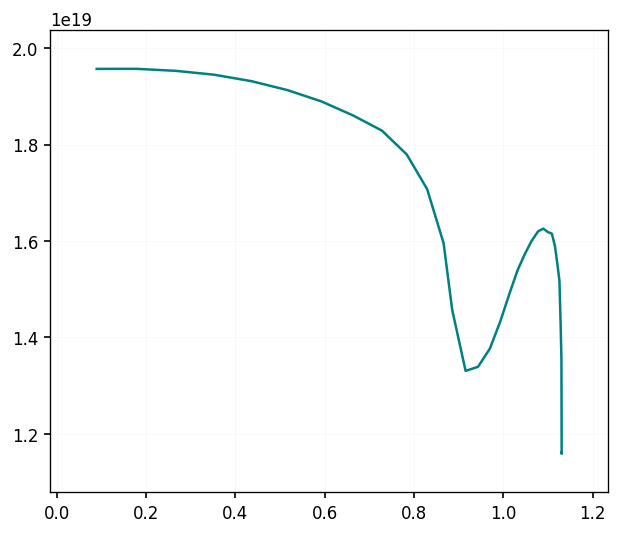

In [16]:
fig, ax = plt.subplots()
b2fgmtry = self.g
ysep = b2fgmtry["sep"]
omp = self.g["omp"]
ix_mid = int((b2fgmtry['rightcut'][1] + b2fgmtry['leftcut'][1]) / 2 - 1)

data = self.bal["ne"][:]
hx = self.bal["hx"][:]

yind = ysep + 0

x = np.cumsum(hx[yind,slice(omp, None)])
y = data[yind, slice(omp,None)]
ax.plot(x, y)

IndexError: index 21 is out of bounds for axis 0 with size 2

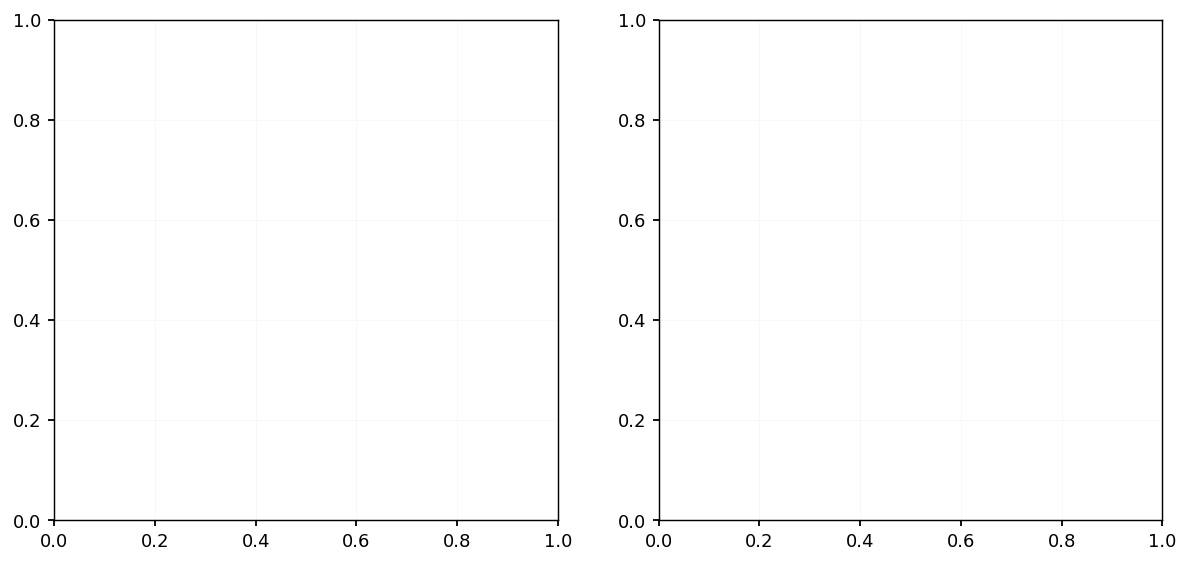

In [17]:
plt.close("all")
fig, axes = plt.subplots(1,2, dpi = 130, width_ratios = (1,1), figsize = (11,5))

# data = rates["2"]["reaction_rate"].transpose()

yind = ysep + 2
param = "ua"
data = self.bal[param][:]
hx = self.bal["hx"][:]

selector = (yind, slice(omp, None))
selector = (yind, slice(None, None))

x = np.cumsum(hx[selector])
y = data[selector]
# axes[0].plot(x, y)
axes[0].plot(y)
axes[0].set_title(f"Poloidal plot of {param}")

# self.plot_2d(param, fig = fig, ax = axes[1], antialias = True, vmin = 1e19, vmax = 2e19)

# R = self.g["R"][selector[::-1]]
# Z = self.g["Z"][selector[::-1]]
# axes[1].scatter(R,Z, color = "deeppink")
# axes[1].set_ylim(-0.87, 0.1)



In [43]:
rates = read_file(os.path.join(solpscases["nsep_2e19"], "rates.pkl"))

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19\rates.pkl loaded


# Without scaling, comparison with SOLEDGE and SOLPS

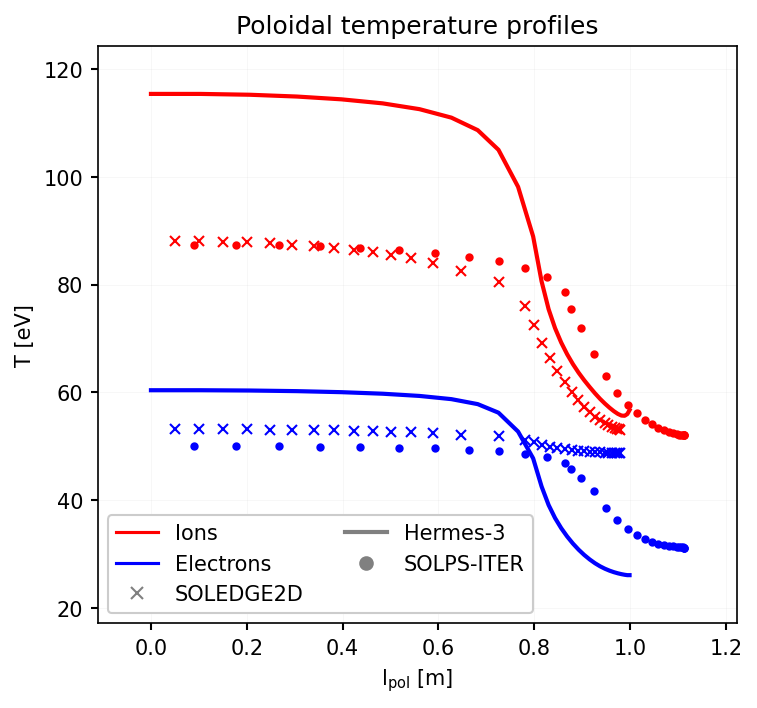

In [32]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]
hr_data = hr["afnE_base"].regions["outer_fieldline"]

slstyle = dict(marker = "x", ms = 5, lw = 0)
hrstyle = dict(lw = 2)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)

ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])
# data = hr_data["Ne"]**2
# ax2 = ax.twinx()
# ax2.plot(sl_data.index, data, c = "grey", lw = 2, ms = 3)

# ax2 = ax.twinx()
# ax2.plot(hr_data.index, hr_data["Rd+_ex"], c = "deeppink", **hrstyle, label = "Radiation")
# ax2.tick_params(axis = "y", colors = "deeppink") 
# ax.plot(hr_data.index, hr_data["Ta"], c = "deeppink", **hrstyle, label = "Neutrals")
# ax2.set_ylabel("Radiation [Wm-2]", color = "deeppink")

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")

yind = ysep + 1
param = "te"
data = self.bal[param][:]
hx = self.bal["hx"][:]

x = np.cumsum(hx[yind,slice(omp, None)])
y = data[yind, slice(omp,None)]
ax.plot(x, self.bal["te"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "b", ms = 3)
ax.plot(x, self.bal["ti"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "r", ms = 3)
# axes[0].set_title(f"Poloidal plot of {param}")

legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 3))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3", "SOLPS-ITER"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# With Qei scaling

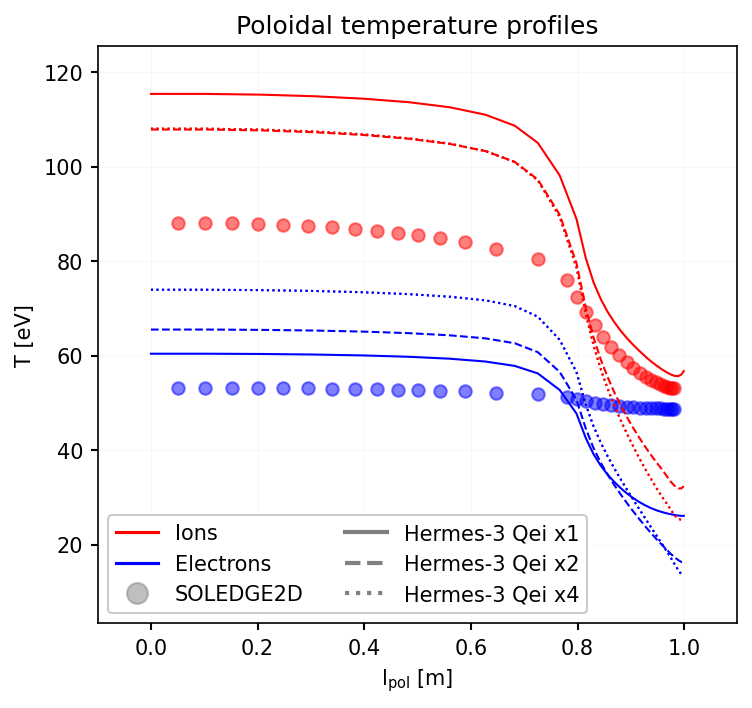

In [38]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]


slstyle = dict(marker = "o", ms = 6, alpha = 0.5, lw = 0)
hrstyle = dict(lw = 1)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)


hr_data = hr["afnE_base"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

hr_data = hr["afnE_qei_x2"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = "--")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = "--")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")

yind = ysep + 1
param = "te"
data = self.bal[param][:]
hx = self.bal["hx"][:]

# x = np.cumsum(hx[yind,slice(omp, None)])
# y = data[yind, slice(omp,None)]
# ax.plot(x, self.bal["te"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "b", ms = 3)
# ax.plot(x, self.bal["ti"][:][yind, slice(omp,None)]/constants("q_e"), marker = "o", lw = 0, c = "r", ms = 3)
# axes[0].set_title(f"Poloidal plot of {param}")

legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 5, alpha = 0.5))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = "--"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = ":"))
# legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3 Qei x1", "Hermes-3 Qei x2", "Hermes-3 Qei x4"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)